# Using regression models to understand the relationship between environmental variables and bike lane use
## Research Question
How does the presence of the following variables affect Bay Wheels usage in different areas of San Francisco?
* Bay Wheels docking stations
* Meters of bike lanes and quality of those lanes
* Land use
* Hill gradient/elevation
* Density
* Average monthly temperature
  
I plan to use a hexagonal grid to place all of these variables, and then run a SGD Regressor analysis to find how they interact. My model will predict how many bike rides start in a particular hexagon. I will train on a 12 month period, and then test on a 4 month period, for a 75:25 split.

## Data Wrangling

### Data Sources
* Bay Wheels Trip History: https://www.lyft.com/bikes/bay-wheels/system-data
* San Francisco Census Data: https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.2020.html#list-tab-1883739534
* Bike Share Stations: https://data.sfgov.org/Transportation/Bay-Area-Bike-Share-Stations/7jbp-yzp3/about_data
* Bike Lane: https://www.sfmta.com/maps/san-francisco-bike-network-map
* Land Use: https://data.sfgov.org/Geographic-Locations-and-Boundaries/Map-of-San-Francisco-Land-Use-2023/k8rg-ihdq

Number of points within bounding box: 338075


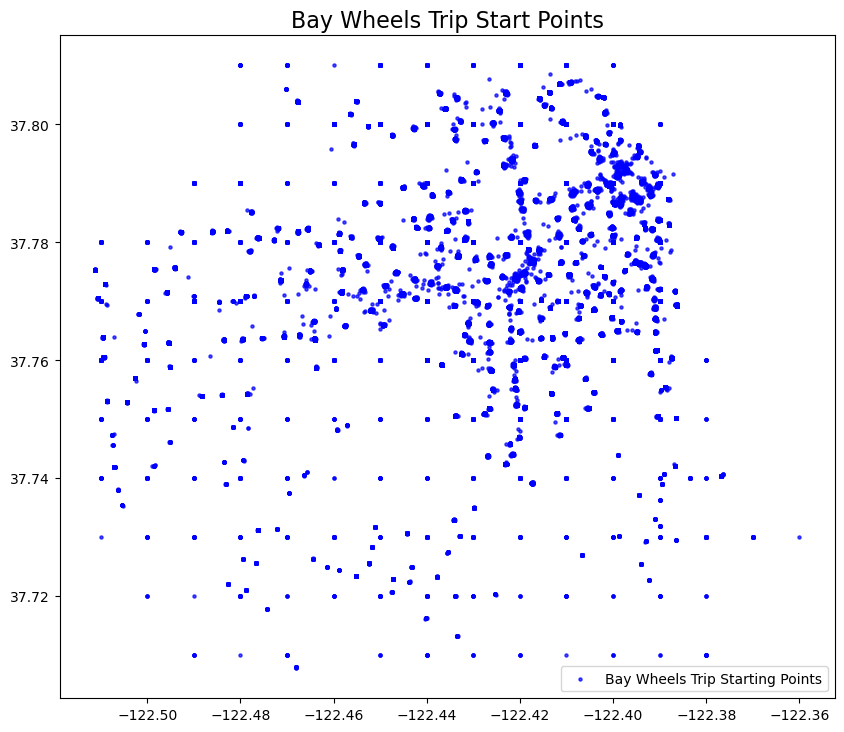

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from h3 import h3
from shapely.geometry import Polygon
from shapely.geometry import box
from shapely.geometry import Point

baywheels_df = pd.read_csv('data/baywheels_data/202410-baywheels-tripdata.csv')
baywheels_gdf = gpd.GeoDataFrame(
    baywheels_df, 
    geometry=gpd.points_from_xy(baywheels_df.start_lng, baywheels_df.start_lat),
    crs="EPSG:4326"  # WGS84 coordinate reference system
)

# Define the bounding box (min_x, min_y, max_x, max_y)
min_x, min_y, max_x, max_y = -122.529488, 37.694416, -122.354736, 37.813581

# Create a bounding box as a Shapely Polygon
bounding_box = box(min_x, min_y, max_x, max_y)

# Filter points within the bounding box
baywheels_gdf = baywheels_gdf[baywheels_gdf.geometry.apply(lambda point: point.within(bounding_box))]

# Verify the results
print(f"Number of points within bounding box: {len(baywheels_gdf)}")

# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))

# Plot Bay Wheels stations (points)
baywheels_gdf.plot(ax=ax, color='blue', markersize=5, alpha=0.7, label='Bay Wheels Trip Starting Points')

# Add title, legend, and adjust
ax.set_title("Bay Wheels Trip Start Points", fontsize=16)
ax.legend()
plt.show()

As shown, we can pull from this the locations of starting points for trips.

### Clean contiguous San Francisco block level shapefile

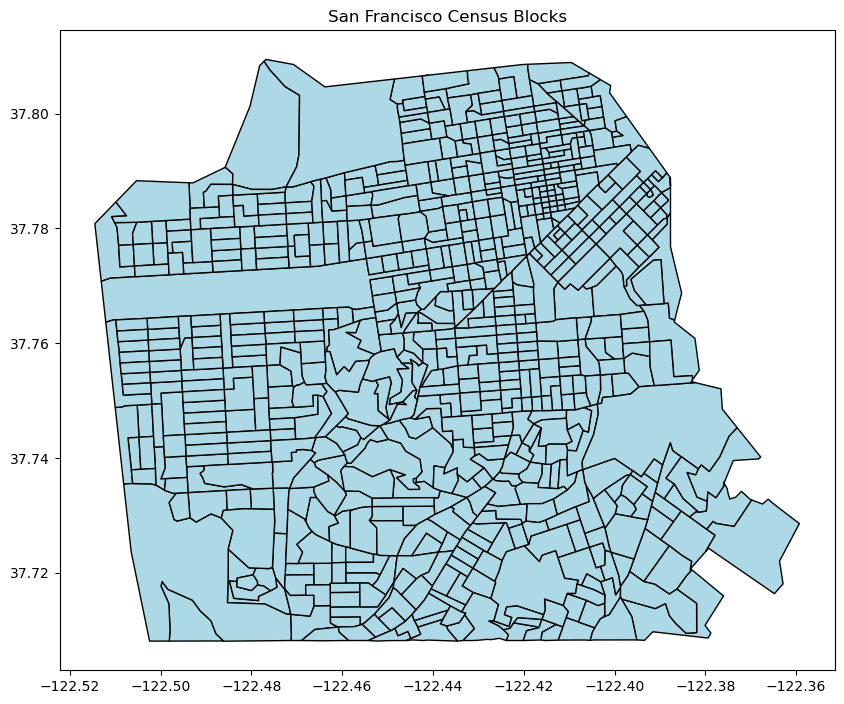

In [2]:
# create h3 map

# Load San Francisco boundary
cal_blocks = gpd.read_file("data/cb_2020_06_bg_500k/cb_2020_06_bg_500k.shp")

sf_blocks = cal_blocks[cal_blocks['COUNTYFP'] == '075']
sf_blocks = sf_blocks.to_crs("EPSG:4326")  # Ensure the CRS is WGS 84

# These extents should be in the format: [min_x, min_y, max_x, max_y] bbox finder
farallon_extent = [-123.027855,37.682787,-122.981850,37.712668]
treasure_island_extent = [-122.382570,37.806088,-122.358023,37.835784]
alameda_extent = [-122.338899,37.773391,-122.313149,37.800388]
alcatraz_extent = [-122.429515,37.823686,-122.416726,37.831414]

# Create bounding boxes (polygons) for each island from the extents
farallon_polygon = box(*farallon_extent)
treasure_island_polygon = box(*treasure_island_extent)
alameda_polygon = box(*alameda_extent)
alcatraz_polygon = box(*alcatraz_extent)

# Combine all island polygons into a single GeoDataFrame
islands = gpd.GeoDataFrame(geometry=[farallon_polygon, treasure_island_polygon, alameda_polygon, alcatraz_polygon], crs=sf_blocks.crs)

# Remove islands from the census blocks using spatial difference
sf_blocks_cleaned = sf_blocks[~sf_blocks.geometry.intersects(islands.unary_union)]

# Plot the cleaned San Francisco census blocks
fig, ax = plt.subplots(figsize=(10, 10))
sf_blocks_cleaned.plot(ax=ax, color='lightblue', edgecolor='black')

ax.set_title("San Francisco Census Blocks")
plt.show()

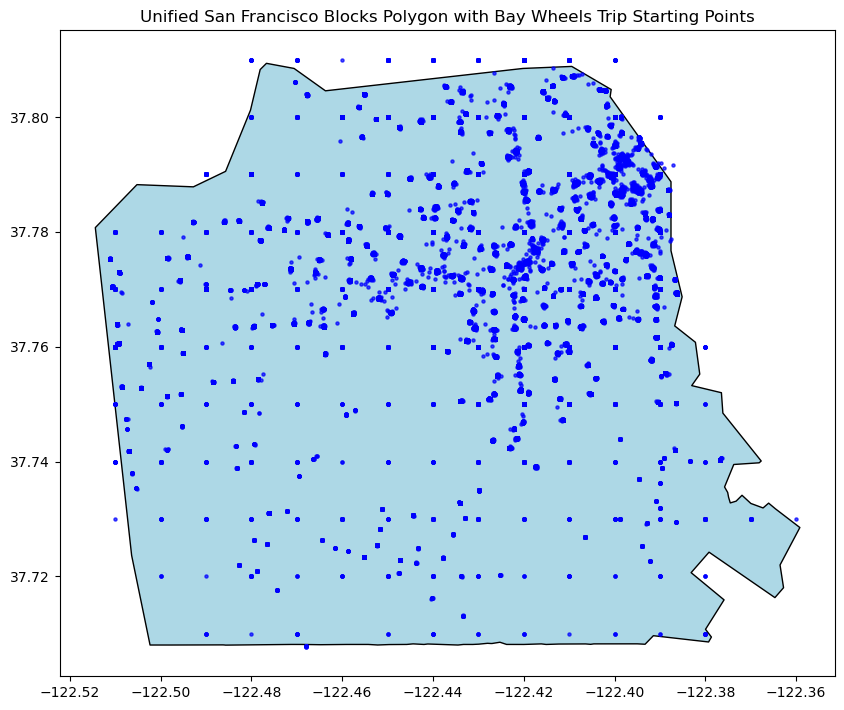

In [3]:
# Perform union of all geometries in sf_blocks_cleaned
unified_polygon = sf_blocks_cleaned.unary_union

# If you want to save the result as a new GeoDataFrame
sf_unified_gdf = gpd.GeoDataFrame({'geometry': [unified_polygon]}, crs=sf_blocks_cleaned.crs)

# Plot to verify
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
sf_unified_gdf.plot(ax=ax, color='lightblue', edgecolor='black')

# Plot Bay Wheels stations (points)
baywheels_gdf.plot(ax=ax, color='blue', markersize=5, alpha=0.7, label='Bay Wheels Trip Starting Points')

ax.set_title("Unified San Francisco Blocks Polygon with Bay Wheels Trip Starting Points")
plt.show()

In [4]:
# Filter points not within the unified polygon
remaining_points = baywheels_gdf[~baywheels_gdf.geometry.within(sf_unified_gdf.iloc[0].geometry)]

# Inspect the first 50 points
print(remaining_points.head(50))

                ride_id  rideable_type               started_at  \
23     42BFD84780B531A9  electric_bike  2024-10-31 08:38:07.329   
46     81CDE8A5D294C676  electric_bike  2024-10-12 15:55:27.878   
240    715BF5A96AD7C20D  electric_bike  2024-10-04 11:00:03.551   
245    1B694A0CE47BF060  electric_bike  2024-10-01 18:12:29.899   
252    52372F67361D4CF9  electric_bike  2024-10-13 17:06:40.540   
264    666A9964AD2C897E  electric_bike  2024-10-25 15:33:46.612   
438    7995CEA6B8288FEF  electric_bike  2024-10-20 17:31:05.199   
503    39DDE5FF87927363  electric_bike  2024-10-06 13:41:46.971   
534    4FAB6598633CADA3  electric_bike  2024-10-22 15:57:04.565   
925    92D1AAB515FBDCAC  electric_bike  2024-10-01 20:17:02.664   
1724   FB66B897F1697E73  electric_bike  2024-10-21 17:34:41.910   
1735   9FEB427081C6B8B6  electric_bike  2024-10-19 18:31:20.089   
1999   7B575C069C98A89B  electric_bike  2024-10-12 12:17:32.651   
2882   1BDE810780138732  electric_bike  2024-10-19 11:22:41.23

As I can see from this, those are points that are actually outside this shapefile (ie- Daly City BART is not in San Francisco) and then everything that has NaN for start_station_name gets assigned one of these "dummy" start points. Need to remove all points that are NaN and see what we have left.

Original Bay Wheels DataFrame: 338075 rows
Cleaned Bay Wheels DataFrame: 321949 rows
Removed: 16126 rows


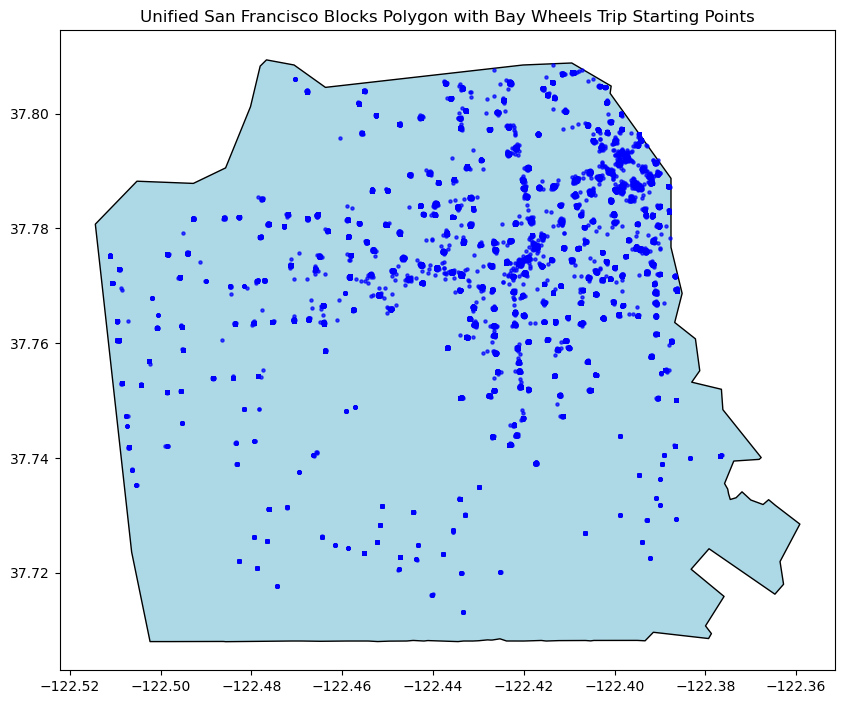

In [5]:
# Remove rows with NaN in 'start_station_name'
cleaned_baywheels_gdf = baywheels_gdf.dropna(subset=['start_station_name'])

# Filter points within the unified San Francisco boundary
cleaned_baywheels_gdf = cleaned_baywheels_gdf[cleaned_baywheels_gdf.geometry.within(sf_unified_gdf.iloc[0].geometry)]

# Verify the cleaned dataset
print(f"Original Bay Wheels DataFrame: {len(baywheels_gdf)} rows")
print(f"Cleaned Bay Wheels DataFrame: {len(cleaned_baywheels_gdf)} rows")
removed_rows = len(baywheels_gdf)-len(cleaned_baywheels_gdf)
print(f"Removed: {removed_rows} rows")

fig, ax = plt.subplots(figsize=(10, 10))
sf_unified_gdf.plot(ax=ax, color='lightblue', edgecolor='black')

# Plot Bay Wheels stations (points)
cleaned_baywheels_gdf.plot(ax=ax, color='blue', markersize=5, alpha=0.7, label='Bay Wheels Trip Starting Points')

ax.set_title("Unified San Francisco Blocks Polygon with Bay Wheels Trip Starting Points")
plt.show()

Looks sparser now, but those points that were aligned in a grid would mess up my analysis by introducing an inaccurate pattern. 

### Generate hexagons using H3 to cover San Francisco area

Number of hexagons: 237
Hex grid CRS: EPSG:2227
San Francisco CRS: EPSG:4326


/var/folders/6b/33d16tr12453_x5yvp1kg99c0000gn/T/ipykernel_45673/1565977280.py:46: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/var/folders/6b/33d16tr12453_x5yvp1kg99c0000gn/T/ipykernel_45673/1565977280.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


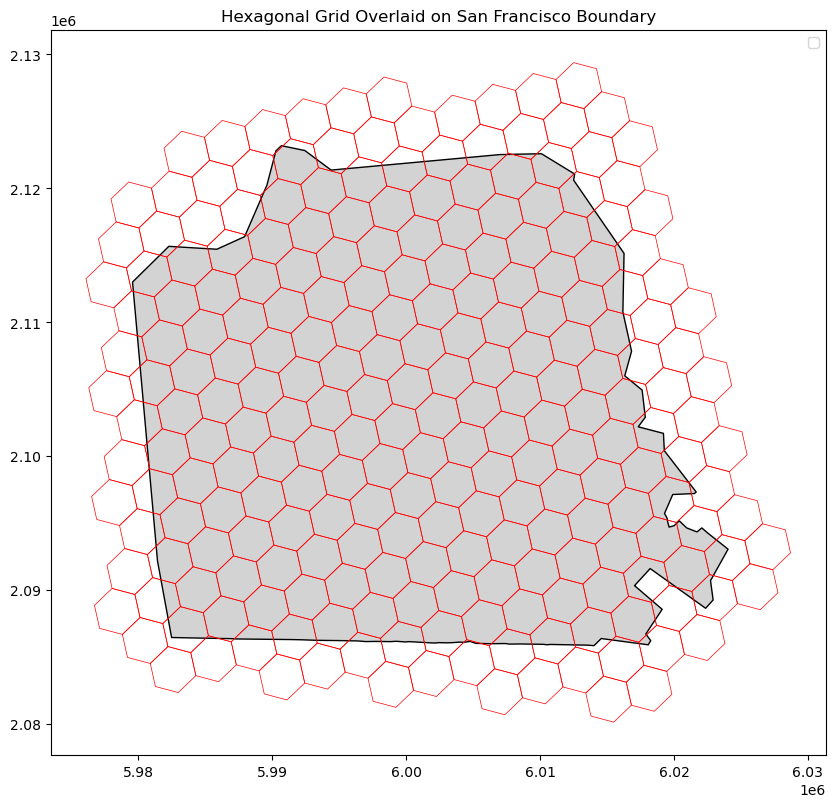

In [6]:
# Ensure the unified GeoDataFrame is in WGS84 for H3
sf_unified_gdf = sf_unified_gdf.to_crs("EPSG:4326")

# https://www.birdtheme.org/useful/v3tool.html Creating simple polygon to cover whole study area
sf_geojson = {'type': 'Polygon',
 'coordinates': [[[37.699970, -122.518409],
[37.696167, -122.381080],
[37.722785, -122.344688],
[37.746135, -122.355674],
[37.809633, -122.383140],
[37.823737, -122.395500],
[37.816685, -122.488883],
[37.797155, -122.523902]]] }

# Generate hexagons using H3
hexagons = list(h3.polyfill(sf_geojson, 8))

# Convert H3 hexagons to Shapely Polygons
hexagon_geometries = [Polygon(h3.h3_to_geo_boundary(h, geo_json=True)) for h in hexagons]

# Create GeoDataFrame from hexagon geometries, keeping CRS as EPSG:4326
hex_grid = gpd.GeoDataFrame({
    'h3_index': hexagons,
    'geometry': hexagon_geometries
}, crs="EPSG:4326")

# Reproject the hex grid to a CRS in meters (e.g., EPSG:2227)
hex_grid = hex_grid.to_crs("EPSG:2227")

# Verify the hex grid matches the San Francisco boundary
sf_unified_gdf = sf_unified_gdf.to_crs("EPSG:2227")

# Check the number of hexagons generated
print(f"Number of hexagons: {len(hexagons)}")

# Verify the CRS of both the hex_grid and sf_boundary
print(f"Hex grid CRS: {hex_grid.crs}")
print(f"San Francisco CRS: {sf_blocks.crs}")

fig, ax = plt.subplots(figsize=(10, 10))
sf_unified_gdf.plot(ax=ax, color='lightgray', edgecolor='black', label='San Francisco Boundary')
hex_grid.plot(ax=ax, color='none', edgecolor='red', linewidth=0.5, label='Hex Grid')

# Add title and legend
ax.set_title("Hexagonal Grid Overlaid on San Francisco Boundary")
ax.legend()
plt.show()

Number of clipped hexagons: 187


/var/folders/6b/33d16tr12453_x5yvp1kg99c0000gn/T/ipykernel_45673/655550357.py:12: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/var/folders/6b/33d16tr12453_x5yvp1kg99c0000gn/T/ipykernel_45673/655550357.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


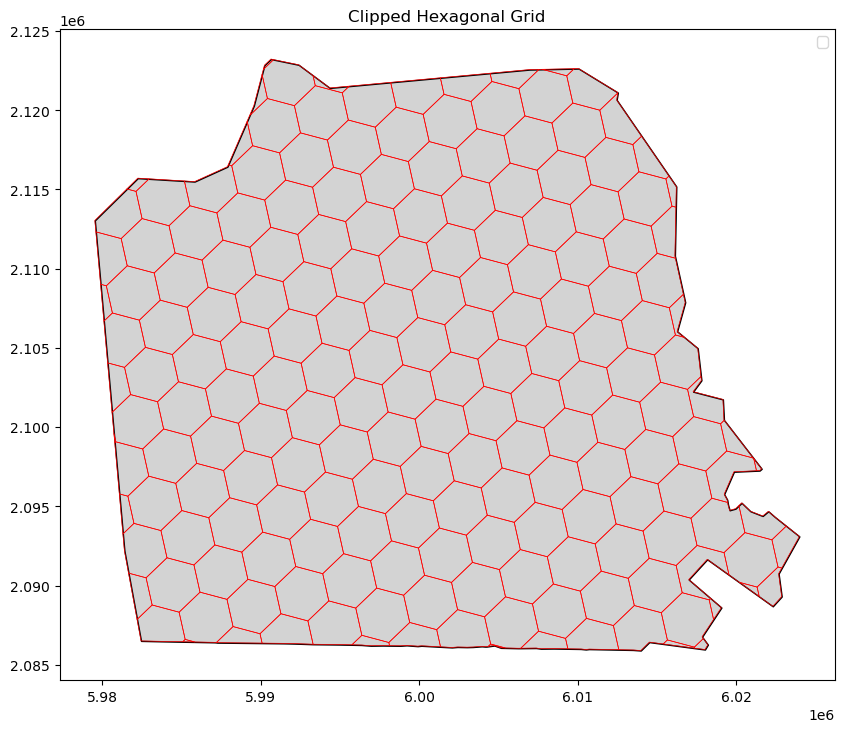

In [7]:
clipped_hex_grid = gpd.clip(hex_grid, sf_unified_gdf)

clipped_hex_grid['area'] = clipped_hex_grid.geometry.area

num_hexagons = len(clipped_hex_grid)
print(f"Number of clipped hexagons: {num_hexagons}")

fig, ax = plt.subplots(figsize=(10, 10))
sf_unified_gdf.plot(ax=ax, color='lightgray', edgecolor='black', label='San Francisco Boundary')
clipped_hex_grid.plot(ax=ax, color='none', edgecolor='red', linewidth=0.5, label='Clipped Hex Grid')
ax.set_title("Clipped Hexagonal Grid")
ax.legend()
plt.show()

### Making Hex/Month Grid

In [8]:
from itertools import product

# List of hex IDs (from clipped_hex_grid)
hex_ids = clipped_hex_grid['h3_index'].unique()

# Generate a range of months (January 2023 to October 2024)
months = pd.date_range(start="2023-01-01", end="2024-10-31", freq='MS').strftime("%Y-%m").tolist()

# Create a baseline DataFrame with all hexes and months
hex_month_grid = pd.DataFrame(list(product(hex_ids, months)), columns=['hex_id', 'month_year'])

# Merge the 'area' column from clipped_hex_grid into hex_month_grid
hex_month_grid = hex_month_grid.merge(
    clipped_hex_grid[['h3_index', 'geometry', 'area']],  # Selecting only the relevant columns
    left_on='hex_id',  # Left DataFrame column
    right_on='h3_index',  # Right DataFrame column
    how='left'  # Left join to keep all rows from hex_month_grid
)

# Drop the 'h3_index' column from hex_month_grid
hex_month_grid = hex_month_grid.drop(columns=['h3_index'])

# Verify the changes
print(hex_month_grid.head())

            hex_id month_year  \
0  8828309555fffff    2023-01   
1  8828309555fffff    2023-02   
2  8828309555fffff    2023-03   
3  8828309555fffff    2023-04   
4  8828309555fffff    2023-05   

                                            geometry           area  
0  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052  
1  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052  
2  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052  
3  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052  
4  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052  


In [9]:
# List of hex IDs (from clipped_hex_grid)
hex_ids = clipped_hex_grid['h3_index'].unique()

# Generate a range of months (January 2023 to October 2024)
months = pd.date_range(start="2023-01-01", end="2024-10-31", freq='MS').strftime("%Y-%m").tolist()

# Create a baseline DataFrame with all hexes and months
hex_month_grid = pd.DataFrame(list(product(hex_ids, months)), columns=['hex_id', 'month_year'])

# Merge the 'area' column from clipped_hex_grid into hex_month_grid
hex_month_grid = hex_month_grid.merge(
    clipped_hex_grid[['h3_index', 'geometry', 'area']],  # Selecting only the relevant columns
    left_on='hex_id',  # Left DataFrame column
    right_on='h3_index',  # Right DataFrame column
    how='left'  # Left join to keep all rows from hex_month_grid
)

# Drop the 'h3_index' column from hex_month_grid
hex_month_grid = hex_month_grid.drop(columns=['h3_index'])

# Now, convert hex_month_grid into a GeoDataFrame
hex_month_grid_gdf = gpd.GeoDataFrame(hex_month_grid, geometry='geometry')

# Set the CRS (replace with the CRS of your original data, if known)
# If clipped_hex_grid has a CRS, you can directly copy it. For example:
hex_month_grid_gdf.set_crs(clipped_hex_grid.crs, allow_override=True, inplace=True)

# Verify the GeoDataFrame
print(hex_month_grid_gdf.head())

            hex_id month_year  \
0  8828309555fffff    2023-01   
1  8828309555fffff    2023-02   
2  8828309555fffff    2023-03   
3  8828309555fffff    2023-04   
4  8828309555fffff    2023-05   

                                            geometry           area  
0  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052  
1  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052  
2  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052  
3  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052  
4  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052  


### Bay Wheels docking stations (static)

In [10]:
# Import and clean Bay Wheels docking stations
# Load docking stations as a GeoDataFrame
docking_stations = gpd.read_file("data/Bay_Area_Bike_Share_Stations_20241204.csv")

# Create a geometry column from Station Latitude and Station Longitude
docking_stations['geometry'] = docking_stations.apply(
    lambda row: Point(row['Station Longitude'], row['Station Latitude']),
    axis=1
)

# Set the GeoDataFrame's CRS to match the coordinate reference system (WGS 84, EPSG:4326)
docking_stations_gpd = gpd.GeoDataFrame(docking_stations, geometry='geometry', crs="EPSG:4326")

# Reproject stations to match hex grid CRS (EPSG:2227)
docking_stations_gpd = docking_stations_gpd.to_crs("EPSG:2227")

# Filter docking stations within San Francisco using spatial intersection
docking_stations_within_sf = gpd.sjoin(
    docking_stations_gpd, 
    sf_unified_gdf, 
    predicate='within', 
    how='inner'
)

# Perform a spatial join to associate each docking station with the corresponding hexagon
docking_stations_in_hex = gpd.sjoin(
    docking_stations_within_sf, 
    clipped_hex_grid, 
    how='inner', 
    predicate='within', 
    lsuffix='_left',  # Adding custom suffix to left dataframe
    rsuffix='_right'  # Adding custom suffix to right dataframe
)

# Now you can count the number of docking stations per hexagon
docking_station_count = docking_stations_in_hex.groupby('h3_index').size().reset_index(name='docking_station_count')

# Check if the merge was successful
print(docking_station_count.columns)  # Ensure this includes 'h3_index' and 'docking_station_count'
print(clipped_hex_grid.columns)  # Verify the column names in the merged DataFrame


# Calculate the number of stations per hexagon and store in a new DataFrame
docking_station_count = docking_stations_in_hex.groupby('h3_index').size().reset_index(name='docking_station_count')

# Check if the merge was successful
print(docking_station_count.columns)  # Ensure this includes 'h3_index' and 'docking_station_count'
print(clipped_hex_grid.columns)  # Verify the column names in the merged DataFrame

# Merge the counts back into the hex grid
clipped_hex_grid = clipped_hex_grid.merge(docking_station_count, on='h3_index', how='left')

# Verify column presence after merge
print(clipped_hex_grid.columns)

# Replace NaN with 0 for hexagons with no stations
clipped_hex_grid['docking_station_count'] = clipped_hex_grid['docking_station_count'].fillna(0)

Index(['h3_index', 'docking_station_count'], dtype='object')
Index(['h3_index', 'geometry', 'area'], dtype='object')
Index(['h3_index', 'docking_station_count'], dtype='object')
Index(['h3_index', 'geometry', 'area'], dtype='object')
Index(['h3_index', 'geometry', 'area', 'docking_station_count'], dtype='object')


/var/folders/6b/33d16tr12453_x5yvp1kg99c0000gn/T/ipykernel_45673/603996422.py:18: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


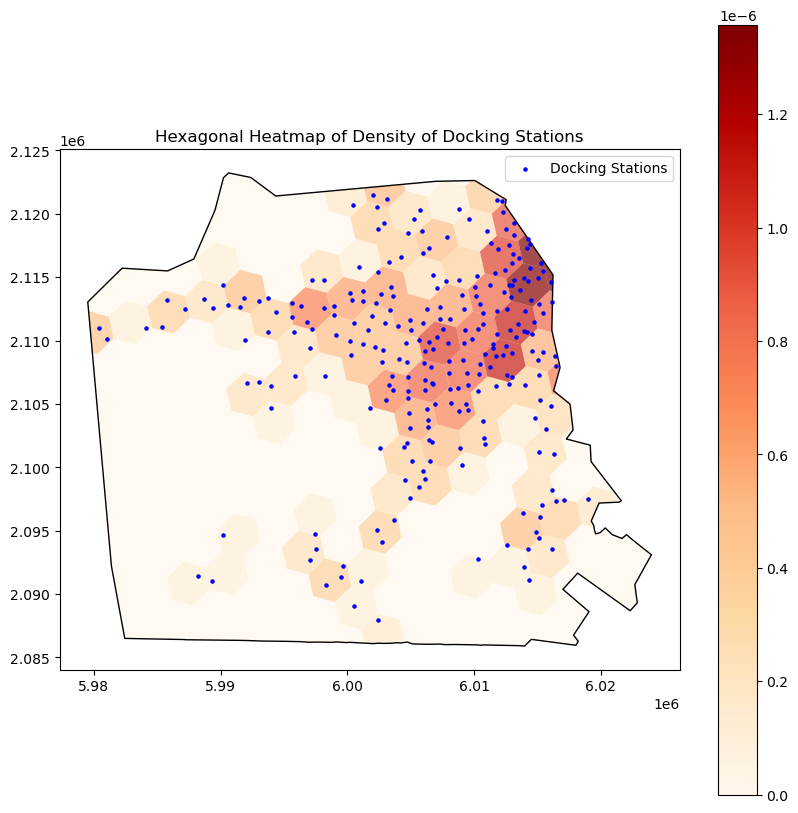

In [11]:
# Calculate docking station density (stations per unit area)
clipped_hex_grid['docking_station_count_density'] = clipped_hex_grid['docking_station_count'] / clipped_hex_grid['area']

# Plot the hex grid heatmap
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the hexagonal heatmap
clipped_hex_grid.plot(column='docking_station_count_density', ax=ax, cmap='OrRd', legend=True, alpha=0.7)

# Plot the San Francisco boundary
sf_unified_gdf.plot(ax=ax, color='none', edgecolor='black', label='SF Boundary')

# Plot the docking stations
docking_stations_within_sf.plot(ax=ax, color='blue', markersize=5, label='Docking Stations')

# Add title and legend
plt.title('Hexagonal Heatmap of Density of Docking Stations')
ax.legend()
plt.show()

In [12]:
print(clipped_hex_grid.head(50))
print(hex_month_grid.head())

           h3_index                                           geometry  \
0   8828309555fffff  POLYGON ((5996380.891 2086860.332, 5998083.382...   
1   882830942dfffff  POLYGON ((5988252.579 2087411.663, 5989954.716...   
2   8828309553fffff  POLYGON ((5989954.716 2086957.954, 5991273.900...   
3   8828309557fffff  POLYGON ((5992976.150 2087767.793, 5994295.368...   
4   8828309425fffff  POLYGON ((5988252.579 2087411.663, 5987869.641...   
5   8828309519fffff  POLYGON ((5991273.900 2088221.493, 5990890.883...   
6   882830951dfffff  POLYGON ((5994295.368 2089031.363, 5993912.274...   
7   882830951bfffff  POLYGON ((5989188.761 2090392.312, 5988805.810...   
8   8828309429fffff  POLYGON ((5985231.408 2086601.874, 5985841.955...   
9   882830942bfffff  POLYGON ((5983146.652 2088772.664, 5984848.547...   
10  8828309421fffff  POLYGON ((5985231.408 2086601.874, 5984848.547...   
11  882830943dfffff  POLYGON ((5982763.855 2090489.680, 5983146.652...   
12  8828309423fffff  POLYGON ((5983146

### Bike Parking Data (Dynamic)

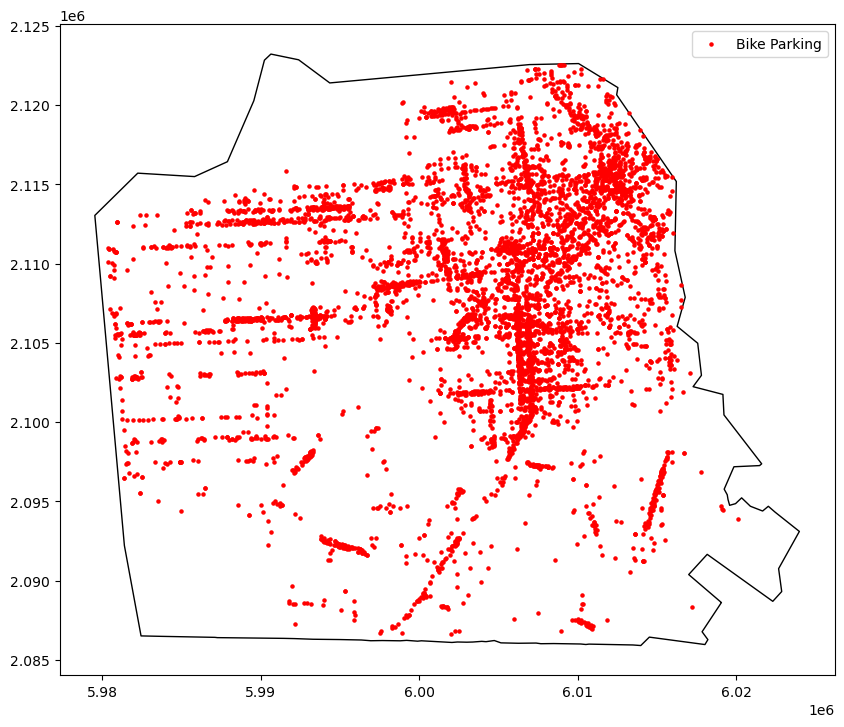

In [13]:
# import and clean bike parking
bike_parking = gpd.read_file("data/Bicycle_Parking_Racks.csv")

# Remove rows with empty "shape" column
bike_parking = bike_parking.dropna(subset=['shape'])

# Check for rows with invalid or empty WKT
invalid_wkt = bike_parking[~bike_parking['shape'].str.startswith("POINT")]

# Remove invalid or empty WKT rows
bike_parking = bike_parking[bike_parking['shape'].str.startswith("POINT")]

# Convert "shape" column into geometries and set CRS
bike_parking['geometry'] = gpd.GeoSeries.from_wkt(bike_parking['shape'])  # Convert WKT to geometries
bike_parking = gpd.GeoDataFrame(bike_parking, geometry='geometry', crs="EPSG:4326")

# Reproject to match sf_unified_gdf CRS
bike_parking = bike_parking.to_crs(sf_unified_gdf.crs)

# Filter points within the study area
bike_parking_within_sf = gpd.sjoin(bike_parking, sf_unified_gdf, predicate='within', how='inner')

# Check results visually (optional)
ax = sf_unified_gdf.plot(color='none', edgecolor='black', figsize=(10, 10))
bike_parking_within_sf.plot(ax=ax, color='red', markersize=5, label='Bike Parking')
plt.legend()
plt.show()

Removing 68 with invalid point data. Visually, the remaining points look correct.

In [14]:
def format_installation_date(row):
    # Convert INSTALL_YR to integer, handling cases where it's a string
    try:
        year = int(row['INSTALL_YR'])
    except ValueError:
        # If it's not a valid number (e.g. empty or invalid data), handle it gracefully
        year = 0
    
    # Apply the logic based on the value of INSTALL_YR
    if pd.isna(year) or year <= 2022:
        return "2022-12"  # Default to December 2022
    
    # Handle missing or empty months in INSTALL_MO
    try:
        # Ensure INSTALL_MO is a valid number or default to 12 (December)
        month = int(row['INSTALL_MO']) if pd.notna(row['INSTALL_MO']) and row['INSTALL_MO'] != '' else 12
    except ValueError:
        month = 12  # Default to December if the month is invalid (e.g., empty string or invalid number)

        # Print out problematic entries where the month is incorrect
        if year > 2022:
            print(f"Problematic entry: Year: {year}, Month: {row['INSTALL_MO']}") 
    
    # Format and return the installation date in "YYYY-MM" format
    return f"{year:04d}-{month:02d}"

# Apply the function
bike_parking_within_sf['installation_month'] = bike_parking_within_sf.apply(format_installation_date, axis=1)

In [15]:
# Perform the spatial join with custom suffixes to avoid name conflicts
bike_parking_with_hex = gpd.sjoin(
    bike_parking_within_sf,
    clipped_hex_grid,
    predicate='within',
    how='inner',
    lsuffix='_bp',  # Suffix for bike parking dataframe
    rsuffix='_hex'  # Suffix for hex grid dataframe
)

# Now proceed with your analysis


In [16]:
print(bike_parking_with_hex.head())

  OBJECTID              ADDRESS                   LOCATION          STREET  \
0    14108      342 30th Street                                30th Street   
1    12183        Belden Street               Belden Place            BUSH   
2    20813  1984 Mission Street                  H&R block  Mission Street   
3    11638       2762 FOLSOM ST              Inglesia Zion          FOLSOM   
4    12367       51 HAVELOCK ST  Balboa Park Swimming Pool        HAVELOCK   

  PLACEMENT RACKS SPACES GLOBALID INSTALL_YR INSTALL_MO  ...  \
0  SIDEWALK     4      8                2021          1  ...   
1  SIDEWALK     2      4                2017          1  ...   
2  SIDEWALK     1      2                2023         11  ...   
3  SIDEWALK     2      4                2011          3  ...   
4  SIDEWALK     2      4                2011          1  ...   

  Central Market/Tenderloin Boundary Polygon - Updated 2 Neighborhoods  \
0                                                                   84  

In [17]:
# Step 1: Create the full grid of hex_id_bp and month_year_bp (covering from 2022-12 to the latest month)
start_date = '2022-12'
end_date = '2024-12'
months = pd.date_range(start=start_date, end=end_date, freq='MS').strftime('%Y-%m')

# We need to create a list of all combinations of hex_id_bp and all months
hex_month_grid_bp = pd.DataFrame(list(product(hex_ids, months)), columns=['hex_id_bp', 'month_year_bp'])

# Step 2: Group by 'h3_index' (hex ID) and 'installation_month', and count the bike parking stations
bike_parking_count = bike_parking_with_hex.groupby(['h3_index', 'installation_month']).size().reset_index(name='bicycle_parking_count')

# Step 3: Rename columns for clarity
bike_parking_count = bike_parking_count.rename(columns={'h3_index': 'hex_id_bp', 'installation_month': 'month_year_bp'})

# Step 4: Sort by 'hex_id_bp' and 'month_year_bp' to ensure the cumulative sum is calculated in order
bike_parking_count = bike_parking_count.sort_values(by=['hex_id_bp', 'month_year_bp'])

# Step 5: Calculate the cumulative sum of bike parking stations by 'hex_id_bp'
bike_parking_count['cumulative_bicycle_parking_count'] = bike_parking_count.groupby('hex_id_bp')['bicycle_parking_count'].cumsum()

# Step 6: Merge with the baseline hex_month_grid, so that we have every month for each hex ID
hex_month_grid_with_bike_parking = hex_month_grid_bp.merge(
    bike_parking_count[['hex_id_bp', 'month_year_bp', 'cumulative_bicycle_parking_count']],
    on=['hex_id_bp', 'month_year_bp'],
    how='left'
)

# Step 7: Forward-fill missing months for each hex_id_bp
# First, make sure all NaNs are properly forward-filled within each hex_id_bp group
hex_month_grid_with_bike_parking['cumulative_bicycle_parking_count'] = hex_month_grid_with_bike_parking.groupby('hex_id_bp')['cumulative_bicycle_parking_count'].ffill()

# Step 8: Fill the first month (2022-12) with 0s where necessary, as they should not have NaN
hex_month_grid_with_bike_parking['cumulative_bicycle_parking_count'] = hex_month_grid_with_bike_parking.groupby('hex_id_bp')['cumulative_bicycle_parking_count'].transform(lambda x: x.fillna(0))

pd.set_option('display.max_rows', 500)

# Display the DataFrame to see the first 50 rows
print(hex_month_grid_with_bike_parking.head(50))

          hex_id_bp month_year_bp  cumulative_bicycle_parking_count
0   8828309555fffff       2022-12                               0.0
1   8828309555fffff       2023-01                               0.0
2   8828309555fffff       2023-02                               0.0
3   8828309555fffff       2023-03                               0.0
4   8828309555fffff       2023-04                               0.0
5   8828309555fffff       2023-05                               0.0
6   8828309555fffff       2023-06                               0.0
7   8828309555fffff       2023-07                               0.0
8   8828309555fffff       2023-08                               0.0
9   8828309555fffff       2023-09                               0.0
10  8828309555fffff       2023-10                               0.0
11  8828309555fffff       2023-11                               0.0
12  8828309555fffff       2023-12                               0.0
13  8828309555fffff       2024-01               

In [18]:
print(hex_month_grid_with_bike_parking.head())
print(hex_month_grid_gdf.head())

         hex_id_bp month_year_bp  cumulative_bicycle_parking_count
0  8828309555fffff       2022-12                               0.0
1  8828309555fffff       2023-01                               0.0
2  8828309555fffff       2023-02                               0.0
3  8828309555fffff       2023-03                               0.0
4  8828309555fffff       2023-04                               0.0
            hex_id month_year  \
0  8828309555fffff    2023-01   
1  8828309555fffff    2023-02   
2  8828309555fffff    2023-03   
3  8828309555fffff    2023-04   
4  8828309555fffff    2023-05   

                                            geometry           area  
0  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052  
1  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052  
2  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052  
3  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052  
4  POLYGON ((5996380.891 2086860.332, 5998083.382

In [19]:
# Merge with only necessary columns
hex_month_grid_gdf = hex_month_grid_gdf.merge(
    hex_month_grid_with_bike_parking[['hex_id_bp', 'month_year_bp', 'cumulative_bicycle_parking_count']], 
    left_on=['hex_id', 'month_year'], 
    right_on=['hex_id_bp', 'month_year_bp'], 
    how='left'
)

In [20]:
hex_month_grid_gdf = hex_month_grid_gdf.drop(columns=['hex_id_bp', 'month_year_bp'])




In [21]:

# Add bicycle_parking_density by dividing cumulative_bicycle_parking_count by area
hex_month_grid_gdf['bicycle_parking_density'] = hex_month_grid_gdf['cumulative_bicycle_parking_count'] / hex_month_grid_gdf['area']


hex_month_grid_gdf.head()

,hex_id,month_year,geometry,area,cumulative_bicycle_parking_count,bicycle_parking_density
0,8828309555fffff,2023-01,"POLYGON ((5996380.891 2086860.332, 5998083.382...",910305.208052,0.0,0.0
1,8828309555fffff,2023-02,"POLYGON ((5996380.891 2086860.332, 5998083.382...",910305.208052,0.0,0.0
2,8828309555fffff,2023-03,"POLYGON ((5996380.891 2086860.332, 5998083.382...",910305.208052,0.0,0.0
3,8828309555fffff,2023-04,"POLYGON ((5996380.891 2086860.332, 5998083.382...",910305.208052,0.0,0.0
4,8828309555fffff,2023-05,"POLYGON ((5996380.891 2086860.332, 5998083.382...",910305.208052,0.0,0.0


In [22]:
hex_month_grid_gdf

,hex_id,month_year,geometry,area,cumulative_bicycle_parking_count,bicycle_parking_density
0,8828309555fffff,2023-01,"POLYGON ((5996380.891 2086860.332, 5998083.382...",910305.208052,0.0,0.000000
1,8828309555fffff,2023-02,"POLYGON ((5996380.891 2086860.332, 5998083.382...",910305.208052,0.0,0.000000
2,8828309555fffff,2023-03,"POLYGON ((5996380.891 2086860.332, 5998083.382...",910305.208052,0.0,0.000000
3,8828309555fffff,2023-04,"POLYGON ((5996380.891 2086860.332, 5998083.382...",910305.208052,0.0,0.000000
4,8828309555fffff,2023-05,"POLYGON ((5996380.891 2086860.332, 5998083.382...",910305.208052,0.0,0.000000
...,...,...,...,...,...,...
4109,88283080ddfffff,2024-06,"POLYGON ((6009313.573 2122170.147, 6007768.596...",446651.398402,5.0,0.000011
4110,88283080ddfffff,2024-07,"POLYGON ((6009313.573 2122170.147, 6007768.596...",446651.398402,5.0,0.000011
4111,88283080ddfffff,2024-08,"POLYGON ((6009313.573 2122170.147, 6007768.596...",446651.398402,5.0,0.000011
4112,88283080ddfffff,2024-09,"POLYGON ((6009313.573 2122170.147, 6007768.596...",446651.398402,5.0,0.000011


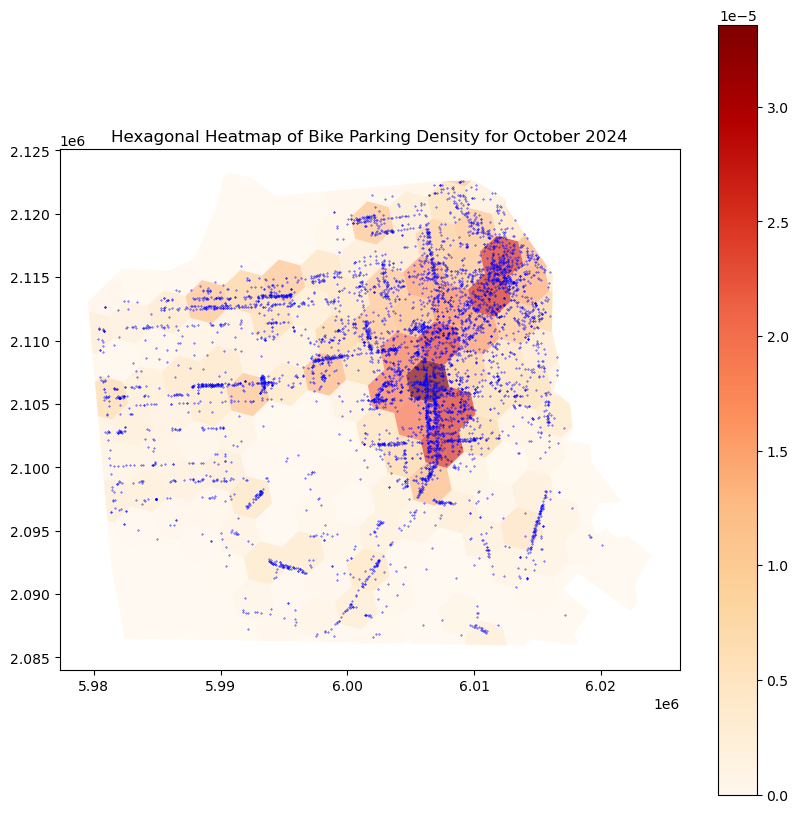

In [23]:
# Step 1: Filter for the data for October 2024
october_2024_data = hex_month_grid_gdf[hex_month_grid_gdf['month_year'] == '2024-10']

# Step 3: Set up the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Step 4: Plot the hexagonal heatmap based on bike parking density
october_2024_data.plot(column='bicycle_parking_density', ax=ax, cmap='OrRd', legend=True, alpha=0.7)

# Step 6: Plot the bike parking stations (if you want to show them)
# Uncomment and replace with your actual GeoDataFrame of bike parking points
bike_parking_within_sf.plot(ax=ax, color='blue', markersize=.1, label='Bike Parking')

# Step 7: Add title and legend
plt.title('Hexagonal Heatmap of Bike Parking Density for October 2024')

# Step 8: Show the plot
plt.show()

### Bike Lane Density (Dynamic)

In [24]:
# import and clean bike lanes
bike_lanes = gpd.read_file("data/MTA_Bike_Network_Linear_Features.csv")

# Apply the function
bike_lanes['installation_month_bl'] = bike_lanes.apply(format_installation_date, axis=1)

bike_lanes.head()

,OBJECTID,CNN,STREETNAME,FROM_ST,TO_ST,FACILITY_T,DIRECT,SURFACE_TR,BARRIER,NOTES,...,CONTRAFLOW,GREENWAVE,BIAP,SM_SWEEPER,shape,RECOMMENDATION,data_as_of,data_loaded_at,geometry,installation_month_bl
0,4614,3467000,CABRILLO ST,ARGUELLO BLVD,2ND AV,CLASS II,2W,,,,...,NO,NO,NO,NO,"LINESTRING (-122.458462902 37.775618427, -122....",1,05/19/2023 01:12:06 PM,07/13/2024 10:07:45 AM,None,2022-12
1,4949,5120000,EL CAMINO DEL MAR,LINCOLN BLVD,25TH AV,CLASS II,2W,,,,...,NO,NO,NO,NO,"LINESTRING (-122.484146101 37.787664873, -122....",0,05/19/2023 01:39:46 PM,07/13/2024 10:07:45 AM,None,2022-12
2,653,4185000,CLEMENT ST,35TH AV,36TH AV,CLASS III,2W,,,,...,NO,NO,NO,NO,"LINESTRING (-122.495590624 37.781527261, -122....",1,05/19/2023 01:12:02 PM,07/13/2024 10:07:45 AM,None,2022-12
3,5060,1372000,25TH AVE,EL CAMINO DEL MAR,LAKE ST,CLASS II,2W,,,,...,NO,NO,NO,NO,"LINESTRING (-122.485283461 37.787611838, -122....",0,05/19/2023 01:39:50 PM,07/13/2024 10:07:45 AM,None,2022-12
4,248,3475000,CABRILLO ST,9TH AV,10TH AV,CLASS II,2W,,,,...,NO,NO,NO,NO,"LINESTRING (-122.467086295 37.775222829, -122....",1,05/19/2023 01:12:02 PM,07/13/2024 10:07:45 AM,None,2022-12


In [25]:
from shapely import wkt
from shapely import LineString

# Step 1: Filter out missing or empty WKT strings
bike_lanes = bike_lanes[bike_lanes['shape'].notna() & (bike_lanes['shape'] != '')]

# Step 2: Convert WKT strings to Shapely geometries
bike_lanes['geometry'] = bike_lanes['shape'].apply(wkt.loads)

# Step 3: Create a GeoDataFrame
bike_lanes = gpd.GeoDataFrame(bike_lanes, geometry='geometry', crs="EPSG:4326")

# Step 4: Reproject to match the CRS of `sf_unified_gdf`
bike_lanes = bike_lanes.to_crs(sf_unified_gdf.crs)

# Verify the result
print(bike_lanes.head())

  OBJECTID      CNN         STREETNAME            FROM_ST    TO_ST FACILITY_T  \
0     4614  3467000        CABRILLO ST      ARGUELLO BLVD   2ND AV   CLASS II   
1     4949  5120000  EL CAMINO DEL MAR       LINCOLN BLVD  25TH AV   CLASS II   
2      653  4185000         CLEMENT ST            35TH AV  36TH AV  CLASS III   
3     5060  1372000           25TH AVE  EL CAMINO DEL MAR  LAKE ST   CLASS II   
4      248  3475000        CABRILLO ST             9TH AV  10TH AV   CLASS II   

  DIRECT SURFACE_TR BARRIER NOTES  ... CONTRAFLOW GREENWAVE BIAP SM_SWEEPER  \
0     2W                           ...         NO        NO   NO         NO   
1     2W                           ...         NO        NO   NO         NO   
2     2W                           ...         NO        NO   NO         NO   
3     2W                           ...         NO        NO   NO         NO   
4     2W                           ...         NO        NO   NO         NO   

                                      

In [26]:
print(bike_lanes.columns)

Index(['OBJECTID', 'CNN', 'STREETNAME', 'FROM_ST', 'TO_ST', 'FACILITY_T',
       'DIRECT', 'SURFACE_TR', 'BARRIER', 'NOTES', 'DIR', 'DOUBLE', 'FY',
       'QTR', 'STREET_', 'LENGTH', 'NUMBER_', 'INSTALL_YR', 'INSTALL_MO',
       'UPDATE_YR', 'UPDATE_MO', 'GLOBALID', 'SYMBOLOGY', 'SHARROW',
       'BUFFERED', 'RAISED', 'CONTRAFLOW', 'GREENWAVE', 'BIAP', 'SM_SWEEPER',
       'shape', 'RECOMMENDATION', 'data_as_of', 'data_loaded_at', 'geometry',
       'installation_month_bl'],
      dtype='object')


In [27]:
# Check the CRS (Coordinate Reference System) of both GeoDataFrames before the join
print(f"Bike lanes CRS: {bike_lanes.crs}")
print(f"Clipped hex grid CRS: {clipped_hex_grid.crs}")

bike_lanes = bike_lanes.drop(columns=['CNN', 'STREETNAME', 'FROM_ST', 'TO_ST', 'FACILITY_T',
       'DIRECT', 'SURFACE_TR', 'BARRIER', 'NOTES', 'DIR', 'DOUBLE', 'FY',
       'QTR', 'STREET_', 'LENGTH', 'NUMBER_',
       'UPDATE_YR', 'UPDATE_MO', 'GLOBALID', 'SHARROW',
       'BUFFERED', 'RAISED', 'CONTRAFLOW', 'GREENWAVE', 'BIAP', 'SM_SWEEPER',
       'RECOMMENDATION', 'data_as_of', 'data_loaded_at'])

# Now perform the spatial join
bike_lanes_with_hex = gpd.sjoin(
    bike_lanes, 
    clipped_hex_grid, 
    how='inner', 
    predicate='intersects', 
    lsuffix='_bike_lane',  # Suffix for bike lane geometry
    rsuffix='_hex'         # Suffix for hexagon geometry
)

# Check the columns to verify that both geometries are present
print(bike_lanes_with_hex.columns)

Bike lanes CRS: EPSG:2227
Clipped hex grid CRS: EPSG:2227
Index(['OBJECTID', 'INSTALL_YR', 'INSTALL_MO', 'SYMBOLOGY', 'shape',
       'geometry', 'installation_month_bl', 'index__hex', 'h3_index', 'area',
       'docking_station_count', 'docking_station_count_density'],
      dtype='object')


In [28]:
bike_lanes_with_hex = bike_lanes_with_hex.drop(columns=['INSTALL_YR', 'index__hex', 'shape', 'INSTALL_MO', 'docking_station_count', 'docking_station_count_density'])

In [29]:

# Verify the changes
print(bike_lanes_with_hex.head())

  OBJECTID   SYMBOLOGY                                           geometry  \
0     4614   BIKE LANE  LINESTRING (5995675.294 2110804.226, 5995349.6...   
1     4949   BIKE LANE  LINESTRING (5988346.994 2115345.952, 5988017.9...   
2      653  BIKE ROUTE  LINESTRING (5984992.958 2113181.953, 5984683.6...   
2      653  BIKE ROUTE  LINESTRING (5984992.958 2113181.953, 5984683.6...   
3     5060   BIKE LANE  LINESTRING (5988017.993 2115333.616, 5988042.7...   

  installation_month_bl         h3_index          area  
0               2022-12  88283095a5fffff  8.243507e+06  
1               2022-12  88283095b7fffff  6.333361e+06  
2               2022-12  88283095b1fffff  8.239998e+06  
2               2022-12  88283095b3fffff  7.559660e+06  
3               2022-12  88283095b7fffff  6.333361e+06  


In [30]:
# Ensure 'h3_index' is the key for merging or lookup
# First, create a lookup dictionary from clipped_hex_grid based on 'h3_index'
hex_lookup = clipped_hex_grid.set_index('h3_index')['geometry'].to_dict()

# Add the geometry to bike_lanes_with_hex based on matching 'h3_index'
bike_lanes_with_hex['hex_geometry'] = bike_lanes_with_hex['h3_index'].map(hex_lookup)

Note- only 22 features were installed 2023-02 and later.

In [31]:
# Perform intersection with hexagons
bike_lanes_with_hex['clipped_geometry'] = bike_lanes_with_hex.apply(
    lambda row: row['geometry'].intersection(row['hex_geometry']), axis=1
)

In [32]:
bike_lanes_with_hex['line_length'] = bike_lanes_with_hex['clipped_geometry'].length

In [33]:
bike_lanes_with_hex.head()

,OBJECTID,SYMBOLOGY,geometry,installation_month_bl,h3_index,area,hex_geometry,clipped_geometry,line_length
0,4614,BIKE LANE,"LINESTRING (5995675.294 2110804.226, 5995349.6...",2022-12,88283095a5fffff,8.243507e+06,"POLYGON ((5994804.973739105 2108273.422228804,...","LINESTRING (5995675.294 2110804.226, 5995349.6...",325.868426
1,4949,BIKE LANE,"LINESTRING (5988346.994 2115345.952, 5988017.9...",2022-12,88283095b7fffff,6.333361e+06,"POLYGON ((5988167.891115938 2116497.321198883,...","LINESTRING (5988346.994 2115345.952, 5988017.9...",329.231590
2,653,BIKE ROUTE,"LINESTRING (5984992.958 2113181.953, 5984683.6...",2022-12,88283095b1fffff,8.239998e+06,"POLYGON ((5984594.459499263 2110991.845003701,...","LINESTRING (5984992.958 2113181.953, 5984694.9...",298.261805
2,653,BIKE ROUTE,"LINESTRING (5984992.958 2113181.953, 5984683.6...",2022-12,88283095b3fffff,7.559660e+06,"POLYGON ((5985530.43477339 2113971.075313069, ...","LINESTRING (5984694.905 2113170.777, 5984683.6...",11.284901
3,5060,BIKE LANE,"LINESTRING (5988017.993 2115333.616, 5988042.7...",2022-12,88283095b7fffff,6.333361e+06,"POLYGON ((5988167.891115938 2116497.321198883,...","LINESTRING (5988017.993 2115333.616, 5988042.7...",680.513501


In [34]:
# Group by hex index, installation month, and bike lane type (SYMBOLOGY), summing up line lengths
monthly_lane_totals = bike_lanes_with_hex.groupby(
    ['h3_index', 'installation_month_bl', 'SYMBOLOGY'], as_index=False
)['line_length'].sum()

In [35]:
monthly_lane_totals.head()

,h3_index,installation_month_bl,SYMBOLOGY,line_length
0,88283080c9fffff,2022-12,BIKE LANE,14678.470728
1,88283080c9fffff,2022-12,BIKE PATH,6106.342200
2,88283080c9fffff,2022-12,BIKE ROUTE,3908.939226
3,88283080c9fffff,2022-12,SEPARATED BIKEWAY,2212.619762
4,88283080c9fffff,2023-01,SEPARATED BIKEWAY,2194.005566


In [36]:
# Generate the full timeline of months
timeline = pd.date_range(start="2022-12", end="2024-10", freq="MS").strftime("%Y-%m").tolist()

# Get unique h3_indices and SYMBOLOGY types
unique_h3_indices = monthly_lane_totals['h3_index'].unique()
unique_symbology = monthly_lane_totals['SYMBOLOGY'].unique()

# Create a complete grid of h3_index, month, and SYMBOLOGY
full_grid = pd.DataFrame(list(product(unique_h3_indices, timeline, unique_symbology)), 
                         columns=['h3_index', 'installation_month_bl', 'SYMBOLOGY'])

In [37]:
# Ensure month format is consistent
monthly_lane_totals['installation_month_bl'] = pd.to_datetime(monthly_lane_totals['installation_month_bl']).dt.strftime("%Y-%m")

# Merge full grid with the existing data
merged_data = full_grid.merge(monthly_lane_totals, 
                              on=['h3_index', 'installation_month_bl', 'SYMBOLOGY'], 
                              how='left').fillna(0)  # Fill missing line_length with 0

In [38]:
# Ensure correct sorting by h3_index, SYMBOLOGY, and month
merged_data = merged_data.sort_values(by=['h3_index', 'SYMBOLOGY', 'installation_month_bl'])

# Calculate cumulative line length
merged_data['cumulative_line_length'] = merged_data.groupby(['h3_index', 'SYMBOLOGY'])['line_length'].cumsum()

In [39]:
# Pivot to create one column for each SYMBOLOGY
pivoted_data = merged_data.pivot_table(
    index=['h3_index', 'installation_month_bl'], 
    columns='SYMBOLOGY', 
    values='cumulative_line_length', 
    fill_value=0
).reset_index()

# Flatten the column index after pivoting
pivoted_data.columns.name = None  # Remove the multi-index

In [40]:
pivoted_data.head()

,h3_index,installation_month_bl,BIKE LANE,BIKE PATH,BIKE ROUTE,NEIGHBORWAY,SEPARATED BIKEWAY
0,88283080c9fffff,2022-12,14678.470728,6106.3422,3908.939226,0.0,2212.619762
1,88283080c9fffff,2023-01,14678.470728,6106.3422,3908.939226,0.0,4406.625327
2,88283080c9fffff,2023-02,14678.470728,6106.3422,3908.939226,0.0,4406.625327
3,88283080c9fffff,2023-03,14678.470728,6106.3422,3908.939226,0.0,4406.625327
4,88283080c9fffff,2023-04,14678.470728,6106.3422,3908.939226,0.0,4406.625327


In [41]:
# Merge the data
merged_data_bl_bp = hex_month_grid_gdf.merge(
    pivoted_data,
    left_on=['hex_id', 'month_year'],
    right_on=['h3_index', 'installation_month_bl'],
    how='left'
).fillna(0)  # Fill missing bike lane data with 0

In [42]:
# Calculate densities for each SYMBOLOGY
symbologies = ['BIKE LANE', 'BIKE PATH', 'BIKE ROUTE', 'NEIGHBORWAY', 'SEPARATED BIKEWAY']
for symbology in symbologies:
    merged_data_bl_bp[f'{symbology}_density'] = merged_data_bl_bp[symbology] / merged_data_bl_bp['area']

# Calculate total density (sum of all SYMBOLOGY types)
merged_data_bl_bp['total_bike_lane_density'] = merged_data_bl_bp[[f'{s}_density' for s in symbologies]].sum(axis=1)

In [43]:
merged_data_bl_bp = merged_data_bl_bp.drop(columns=['h3_index', 'installation_month_bl'])

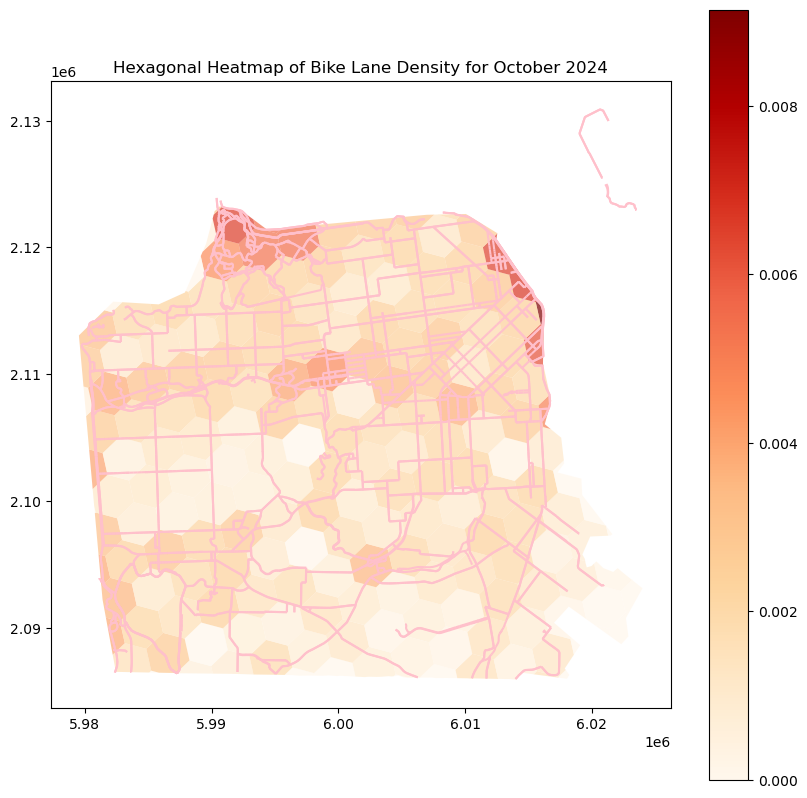

In [44]:
# Step 1: Filter for the data for October 2024
october_2024_data = merged_data_bl_bp[merged_data_bl_bp['month_year'] == '2024-10']

# Step 3: Set up the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Step 4: Plot the hexagonal heatmap based on bike parking density
october_2024_data.plot(column='total_bike_lane_density', ax=ax, cmap='OrRd', legend=True, alpha=0.7)

# Step 6: Plot the bike parking stations (if you want to show them)
# Uncomment and replace with your actual GeoDataFrame of bike parking points
bike_lanes.plot(ax=ax, color='pink', markersize=.1, label='Bike Parking')

# Step 7: Add title and legend
plt.title('Hexagonal Heatmap of Bike Lane Density for October 2024')

# Step 8: Show the plot
plt.show()

Checked this against the map on SFMTA data website to make sure everything looked correct.

### Land Use

In [82]:
# import and clean land use
land_use = gpd.read_file("data/San_Francisco_Land_Use_-_2023_20241206.csv")

In [83]:
print(land_use.columns)

Index(['the_geom', 'mapblklot', 'restype', 'res', 'total', 'cie', 'med',
       'mips', 'retail', 'pdr', 'visitor', 'resunits', 'landuse', 'from_st',
       'to_st', 'street', 'st_type', 'geometry'],
      dtype='object')


In [84]:
land_use = land_use.drop(columns=['mapblklot', 'restype', 'res', 'total', 'cie', 'med',
       'mips', 'retail', 'pdr', 'visitor', 'resunits', 'from_st',
       'to_st', 'street', 'st_type', 'geometry'])

In [85]:
from shapely.wkt import loads
land_use['the_geom'] = land_use['the_geom'].apply(loads)
land_use = gpd.GeoDataFrame(land_use, geometry='the_geom')

In [86]:
land_use.head()

,the_geom,landuse
0,"MULTIPOLYGON (((-122.44480 37.77550, -122.4450...",RESIDENT
1,"MULTIPOLYGON (((-122.44478 37.77543, -122.4450...",RESIDENT
2,"MULTIPOLYGON (((-122.44477 37.77536, -122.4450...",RESIDENT
3,"MULTIPOLYGON (((-122.44507 37.77512, -122.4450...",MIXRES
4,"MULTIPOLYGON (((-122.44507 37.77512, -122.4451...",RESIDENT


In [87]:
# Assign the CRS to EPSG:4326
land_use = land_use.set_crs("EPSG:4326")

In [88]:
land_use.head()

,the_geom,landuse
0,"MULTIPOLYGON (((-122.44480 37.77550, -122.4450...",RESIDENT
1,"MULTIPOLYGON (((-122.44478 37.77543, -122.4450...",RESIDENT
2,"MULTIPOLYGON (((-122.44477 37.77536, -122.4450...",RESIDENT
3,"MULTIPOLYGON (((-122.44507 37.77512, -122.4450...",MIXRES
4,"MULTIPOLYGON (((-122.44507 37.77512, -122.4451...",RESIDENT


In [89]:
# transform crs of land_use
land_use = land_use.to_crs("EPSG:2227")

In [90]:
land_use.head()

,the_geom,landuse
0,"MULTIPOLYGON (((5999623.608 2110677.107, 59995...",RESIDENT
1,"MULTIPOLYGON (((5999626.956 2110652.900, 59995...",RESIDENT
2,"MULTIPOLYGON (((5999630.301 2110628.713, 59995...",RESIDENT
3,"MULTIPOLYGON (((5999541.773 2110542.464, 59995...",MIXRES
4,"MULTIPOLYGON (((5999541.773 2110542.464, 59995...",RESIDENT


In [91]:
# pull h3_index, geometry, area from clipped_hex_grid as land_use_hex and work with that
land_use_hex = clipped_hex_grid[['h3_index', 'geometry', 'area']]

In [92]:
land_use_hex.head()

,h3_index,geometry,area
0,8828309555fffff,"POLYGON ((5996380.891 2086860.332, 5998083.382...",9.103052e+05
1,882830942dfffff,"POLYGON ((5988252.579 2087411.663, 5989954.716...",1.955172e+06
2,8828309553fffff,"POLYGON ((5989954.716 2086957.954, 5991273.900...",4.648840e+06
3,8828309557fffff,"POLYGON ((5992976.150 2087767.793, 5994295.368...",7.221323e+06
4,8828309425fffff,"POLYGON ((5988252.579 2087411.663, 5987869.641...",8.247347e+06


In [127]:
land_use_hex['area'].sum()

1305783373461.8577

In [93]:
print(land_use.crs, sf_unified_gdf.crs)

EPSG:2227 EPSG:2227


In [94]:
overlap_check = gpd.sjoin(land_use, sf_unified_gdf, how='inner', predicate='intersects')
print(f"Number of overlapping geometries: {len(overlap_check)}")

Number of overlapping geometries: 153527


In [97]:
# clip all geometry to study area
land_use_2 = gpd.overlay(land_use, sf_unified_gdf, how='intersection')

In [98]:
land_use_2.head()

,landuse,geometry
0,RESIDENT,"POLYGON ((5999543.499 2110665.978, 5999543.955..."
1,RESIDENT,"POLYGON ((5999543.154 2110641.257, 5999543.499..."
2,RESIDENT,"POLYGON ((5999542.809 2110616.558, 5999543.154..."
3,MIXRES,"POLYGON ((5999542.117 2110567.096, 5999636.999..."
4,RESIDENT,"POLYGON ((5999522.565 2110539.795, 5999505.488..."
5,RESIDENT,"POLYGON ((5999341.306 2110514.613, 5999330.816..."
6,RESIDENT,"POLYGON ((5999443.367 2110528.793, 5999424.228..."
7,RESIDENT,"POLYGON ((5999346.970 2110653.565, 5999337.205..."
8,RESIDENT,"POLYGON ((5999417.615 2110525.215, 5999398.475..."
9,RESIDENT,"POLYGON ((5999469.120 2110532.370, 5999449.980..."


In [99]:
land_use_2_test = land_use_2[land_use_2['landuse'] == '']

Some are missing a landuse column- after mapping these appear to be mostly residential areas. Replaced.

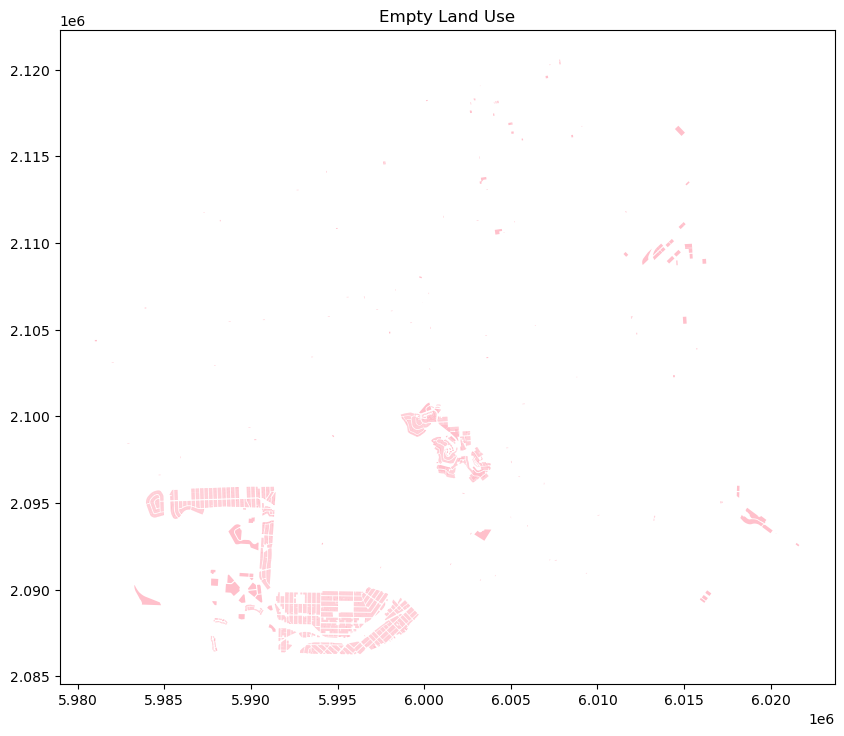

In [100]:
# Step 3: Set up the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Step 6: Plot the bike parking stations (if you want to show them)
# Uncomment and replace with your actual GeoDataFrame of bike parking points
land_use_2_test.plot(ax=ax, color='pink', markersize=.1, label='Bike Parking')

# Step 7: Add title and legend
plt.title('Empty Land Use')

# Step 8: Show the plot
plt.show()

In [101]:
land_use_2.loc[land_use_2['landuse'] == '', 'landuse'] = 'RESIDENT'

In [103]:
overlap_check = gpd.sjoin(land_use_2, sf_unified_gdf, how='inner', predicate='intersects')
print(f"Number of overlapping geometries: {len(overlap_check)}")

Number of overlapping geometries: 153527


In [104]:
print(land_use_2.head())
print(land_use_2.shape)

    landuse                                           geometry
0  RESIDENT  POLYGON ((5999543.499 2110665.978, 5999543.955...
1  RESIDENT  POLYGON ((5999543.154 2110641.257, 5999543.499...
2  RESIDENT  POLYGON ((5999542.809 2110616.558, 5999543.154...
3    MIXRES  POLYGON ((5999542.117 2110567.096, 5999636.999...
4  RESIDENT  POLYGON ((5999522.565 2110539.795, 5999505.488...
(153527, 2)


In [105]:
# Perform the overlay with 'intersection' to retain land use labels
land_use_hex = gpd.overlay(land_use_2, land_use_hex, how='intersection')

In [106]:
print(land_use_hex.head())
print(land_use_hex.crs)

    landuse         h3_index          area  \
0  RESIDENT  8828308299fffff  8.244116e+06   
1  RESIDENT  8828308299fffff  8.244116e+06   
2  RESIDENT  8828308299fffff  8.244116e+06   
3    MIXRES  8828308299fffff  8.244116e+06   
4  RESIDENT  8828308299fffff  8.244116e+06   

                                            geometry  
0  POLYGON ((5999543.955 2110698.601, 5999619.189...  
1  POLYGON ((5999543.499 2110665.978, 5999623.608...  
2  POLYGON ((5999543.154 2110641.257, 5999626.956...  
3  POLYGON ((5999636.999 2110580.278, 5999640.335...  
4  POLYGON ((5999505.488 2110660.697, 5999518.448...  
EPSG:2227


In [107]:
# add up the square m by land use type, which is in the column landuse
land_use_hex['land_use_area'] = land_use.geometry.area

In [108]:
land_use_summary = land_use_hex.groupby(['h3_index', 'landuse'])['land_use_area'].sum().reset_index()

In [71]:
land_use_summary.head()

,h3_index,landuse,land_use_area
0,88283080c9fffff,CIE,65236.507366
1,88283080c9fffff,MIPS,157767.046546
2,88283080c9fffff,MIXED,170997.661600
3,88283080c9fffff,MIXRES,154780.015391
4,88283080c9fffff,OPENSPACE,16798.442744
5,88283080c9fffff,PDR,23440.358854
6,88283080c9fffff,RESIDENT,811306.559631
7,88283080c9fffff,RETAIL/ENT,29223.244933
8,88283080c9fffff,VACANT,263894.116137
9,88283080cbfffff,CIE,8620.396565


In [109]:
# Pivot the table
land_use_wide = land_use_summary.pivot_table(
    index='h3_index', 
    columns='landuse', 
    values='land_use_area', 
    fill_value=0
).reset_index()

In [114]:
# make lookup table
hex_lookup_area = clipped_hex_grid.set_index('h3_index')['area'].to_dict()

# Add the geometry to land_use_wide based on matching 'h3_index'
land_use_wide['area'] = land_use_summary['h3_index'].map(hex_lookup_area)

In [115]:
land_use_wide.columns

Index(['h3_index', 'CIE', 'MED', 'MIPS', 'MIXED', 'MIXRES', 'OPENSPACE', 'PDR',
       'RESIDENT', 'RETAIL/ENT', 'VACANT', 'VISITOR', 'area'],
      dtype='object', name='landuse')

In [116]:
land_use_wide.head()

landuse,h3_index,CIE,MED,MIPS,MIXED,MIXRES,OPENSPACE,PDR,RESIDENT,RETAIL/ENT,VACANT,VISITOR,area
0,88283080c9fffff,15842.074787,0.0,243747.799990,170343.476567,150546.170022,22362.853934,29058.782425,4.117068e+05,27720.227697,240632.299493,0.0,4.475138e+06
1,88283080cbfffff,9040.317348,0.0,20797.821056,19353.232486,431123.057424,24067.072987,3462.572175,1.101810e+06,8072.346059,145833.392486,0.0,4.475138e+06
2,88283080d9fffff,0.000000,0.0,2346.097140,7284.783960,22951.120035,17344.662126,0.000000,4.194173e+04,5782.389613,21292.701036,0.0,4.475138e+06
3,88283080ddfffff,0.000000,0.0,0.000000,9026.328576,0.000000,8435.099214,0.000000,0.000000e+00,7523.860765,14487.194474,0.0,4.475138e+06
4,8828308201fffff,0.000000,0.0,5000.034966,2490.168176,1763.154120,11875.027136,0.000000,7.170154e+03,0.000000,269788.627224,0.0,4.475138e+06


In [118]:
# Assuming the total area is in the 'area' column, we calculate coverage for each land use type
land_use_coverage = land_use_wide.copy()

# List of land use types (these are the columns except for 'h3_index' and 'area')
land_use_columns = ['CIE', 'MED', 'MIPS', 'MIXED', 'MIXRES', 'OPENSPACE', 'PDR', 'RESIDENT', 'RETAIL/ENT', 'VACANT', 'VISITOR']

# Create a new column for coverage by dividing each land use area by the total area
for landusetype in land_use_columns:
    land_use_coverage[f'{landusetype}_coverage'] = land_use_coverage[landusetype] / land_use_coverage['area']

# Display the updated dataframe
print(land_use_coverage[['h3_index'] + land_use_columns + [f'{landuse}_coverage' for landuse in land_use_columns]].head())

landuse         h3_index           CIE  MED           MIPS          MIXED  \
0        88283080c9fffff  15842.074787  0.0  243747.799990  170343.476567   
1        88283080cbfffff   9040.317348  0.0   20797.821056   19353.232486   
2        88283080d9fffff      0.000000  0.0    2346.097140    7284.783960   
3        88283080ddfffff      0.000000  0.0       0.000000    9026.328576   
4        8828308201fffff      0.000000  0.0    5000.034966    2490.168176   

landuse         MIXRES     OPENSPACE           PDR      RESIDENT  \
0        150546.170022  22362.853934  29058.782425  4.117068e+05   
1        431123.057424  24067.072987   3462.572175  1.101810e+06   
2         22951.120035  17344.662126      0.000000  4.194173e+04   
3             0.000000   8435.099214      0.000000  0.000000e+00   
4          1763.154120  11875.027136      0.000000  7.170154e+03   

landuse    RETAIL/ENT  ...  MED_coverage  MIPS_coverage  MIXED_coverage  \
0        27720.227697  ...           0.0       0.0544

In [120]:
# List of land use types (these are the columns except for 'h3_index' and 'area')
coverage_columns = ['CIE_coverage', 'MED_coverage', 'MIPS_coverage', 'MIXED_coverage', 'MIXRES_coverage', 'OPENSPACE_coverage', 'PDR_coverage', 'RESIDENT_coverage', 'RETAIL/ENT_coverage', 'VACANT_coverage', 'VISITOR_coverage']

# Calculate the sum of all coverage columns for each row
land_use_coverage['total_coverage'] = land_use_coverage[coverage_columns].sum(axis=1)

# Create a new column 'sidewalk_street_coverage' as 100 - total_coverage
land_use_coverage['sidewalk_street_coverage'] = 100 - land_use_coverage['total_coverage']

# Display the updated dataframe
print(land_use_coverage[['h3_index'] + coverage_columns + ['total_coverage', 'sidewalk_street_coverage']].head())

landuse         h3_index  CIE_coverage  MED_coverage  MIPS_coverage  \
0        88283080c9fffff       0.00354           0.0       0.054467   
1        88283080cbfffff       0.00202           0.0       0.004647   
2        88283080d9fffff       0.00000           0.0       0.000524   
3        88283080ddfffff       0.00000           0.0       0.000000   
4        8828308201fffff       0.00000           0.0       0.001117   

landuse  MIXED_coverage  MIXRES_coverage  OPENSPACE_coverage  PDR_coverage  \
0              0.038064         0.033641            0.004997      0.006493   
1              0.004325         0.096337            0.005378      0.000774   
2              0.001628         0.005129            0.003876      0.000000   
3              0.002017         0.000000            0.001885      0.000000   
4              0.000556         0.000394            0.002654      0.000000   

landuse  RESIDENT_coverage  RETAIL/ENT_coverage  VACANT_coverage  \
0                 0.091999          

,h3_index,landuse,land_use_area,area_x,area_y
0,88283080c9fffff,CIE,65236.507366,4.475138e+06,4.475138e+06
1,88283080c9fffff,CIE,65236.507366,4.475138e+06,4.475138e+06
2,88283080c9fffff,CIE,65236.507366,4.475138e+06,4.475138e+06
3,88283080c9fffff,CIE,65236.507366,4.475138e+06,4.475138e+06
4,88283080c9fffff,CIE,65236.507366,4.475138e+06,4.475138e+06
5,88283080c9fffff,CIE,65236.507366,4.475138e+06,4.475138e+06
6,88283080c9fffff,CIE,65236.507366,4.475138e+06,4.475138e+06
7,88283080c9fffff,CIE,65236.507366,4.475138e+06,4.475138e+06
8,88283080c9fffff,CIE,65236.507366,4.475138e+06,4.475138e+06
9,88283080c9fffff,CIE,65236.507366,4.475138e+06,4.475138e+06


KeyError: 'area'

### Hill Gradient

In [77]:
# import and clean hill gradient

### Population Density

In [78]:
# import and clean density

#### Static features align

In [79]:
# Assuming clipped_hex_grid contains static data columns:
# docking_station_count, land_use_type, population_density, elevation

static_features = clipped_hex_grid[['h3_index', 'docking_station_count_density', 
                                    'land_use_type', 'population_density', 
                                    'elevation']].rename(columns={'h3_index': 'hex_id'})

# Example static_features DataFrame
print(static_features.head())

KeyError: "['land_use_type', 'population_density', 'elevation'] not in index"

In [ ]:
# Merge static features into the hex_month_grid
hex_month_grid = hex_month_grid.merge(static_features, on='hex_id', how='left')

# Example output after merge
print(hex_month_grid.head())